In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
from itertools import accumulate

In [78]:
nCells = (10,10,10)
cellSize = (3,3,12)

In [4]:
def onAxis_SolidAngle(a, b, d):
    alpha = a/(2*d)
    beta  = b/(2*d)
    return 4*np.arcsin(alpha*beta/np.sqrt((1+alpha**2)*(1+beta**2)))

In [8]:
def offAxis_SolidAngle(A, B, a, b, d):
    sign_A = np.sign(A)
    A *= sign_A
    sign_B = np.sign(B)
    B *= sign_B

    o1 = onAxis_SolidAngle(2*(a+sign_A*A), 2*(b+sign_B*B), d)
    o2 = onAxis_SolidAngle(2*A,            2*(b+sign_B*B), d)
    o3 = onAxis_SolidAngle(2*(a+sign_A*A), 2*B,            d)
    o4 = onAxis_SolidAngle(2*A,            2*B,            d)

    return (o1 - sign_A*o2 - sign_B*o3 + sign_A*sign_B*o4)/4


In [131]:
def generate_tuples_two_integers(n):
    """
    Generate all tuples of two integers (a, b) such that
    the sum of their absolute values equals n.

    Parameters:
        n (int): Target sum of absolute values.

    Returns:
        list of tuples: List of (a, b) satisfying the condition.
    """
    result = []
    for a in range(-n, n + 1):  # Iterate over possible values of a
        b_abs = n - abs(a)      # Compute the absolute value of b
        if b_abs >= 0:          # Ensure b_abs is non-negative
            # Add both positive and negative combinations of b
            result.append((a, b_abs))
            if b_abs != 0:  # Avoid duplicates when b_abs is 0
                result.append((a, -b_abs))
    return result


def all_reflections(n):
    """
    Generate all possible reflection paths such that
    the total amount of reflections equals n. A reflection 
    path is a (x, y, z) tuple where each coordinate is a
    (positive or negative) integer which signifies the amount
    of times a ray reflected in that direction.
    Positive values mean that the ray first reflected in the face
    in the positive direction of the axis and viceversa.

    Parameters:
        n (int): Target number of reflections.

    Returns:
        list of tuples: List of (x,y,z) satisfying the condition.
    """
    paths_horizontal = generate_tuples_two_integers(n)
    paths_vertical = generate_tuples_two_integers(n-1)
    paths = [(x, 0, z) for x, z in paths_horizontal] + [(x, -1, z) for x, z in paths_vertical]
    return paths
    

([<matplotlib.axis.XTick at 0x7efcab43c1f0>,
 [Text(0, 0, '0'),
  Text(2, 0, '2'),
  Text(4, 0, '4'),
  Text(6, 0, '6'),
  Text(8, 0, '8'),
  Text(10, 0, '10'),
  Text(12, 0, '12'),
  Text(14, 0, '14'),
  Text(16, 0, '16'),
  Text(18, 0, '18'),
  Text(20, 0, '20')])

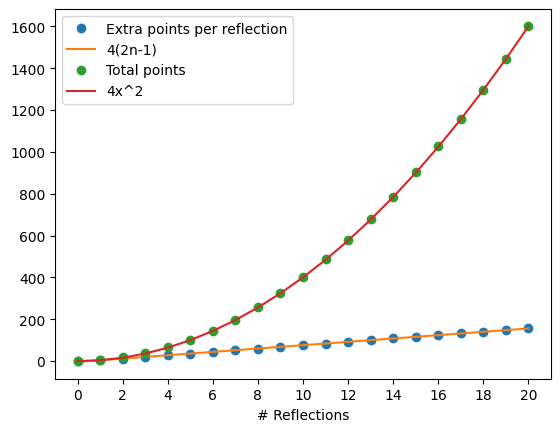

In [132]:
x = np.arange(0,21)
n_extra_point = [len(all_reflections(n)) for n in x]
total_point = list(accumulate(n_extra_point))
plt.plot(x, n_extra_point, 'o', label="Extra points per reflection")
plt.plot(x, 4*(2*x-1), '-', label='4(2n-1)')
plt.plot(x, total_point, 'o', label='Total points')
plt.plot(x, 4*x**2, label='4x^2')
plt.legend()
plt.xlabel("# Reflections")
plt.xticks(np.arange(0, 22, 2))

In [ ]:
def reflect(old_coordinates, reflection):
    reflection = list(reflection)
    nc = list(old_coordinates) # new coordinates
    for dim in range(len(old_coordinates)):
        if reflection[dim] != 0:
            sign = np.sign(reflection[dim])
            reflection[dim] *= sign 
            partial_shift = reflection[dim]%2
            if partial_shift:
                if sign>0:
                    nc[dim] = 2*nCells[dim]-1-old_coordinates[dim]
                else:
                    nc[dim] = -1*old_coordinates[dim]-1
            whole_shifts = reflection[dim]//2
            nc[dim] += whole_shifts*sign*2*nCells[dim]
    return nc

In [144]:
def find_distances(edep_idx, sensor_idx):
    shift_x = abs(edep_idx[0] - sensor_idx[0])
    if shift_x == 0:
        A = -0.5*cellSize[0]
    else:
        A = cellSize[0]*(shift_x-1+0.5)
    d = cellSize[1]*(nCells[1]-1-edep_idx[1]+0.5)
    shift_z = abs(edep_idx[2] - sensor_idx[1])
    if shift_z == 0:
        B = -0.5*cellSize[2]
    else:
        B = cellSize[2]*(shift_z-1+0.5)
    return A, B, d

In [145]:
def compute_angles(edep_idx, sensor_idx, N):
    reflections = [all_reflections(n) for n in range(N+1)]
    new_coordinates = [[reflect(edep_idx, r) for r in ref] for ref in reflections]
    distances = [[find_distances(edep, sensor_idx) for edep in n] for n in new_coordinates]
    omegas = [[offAxis_SolidAngle(A, B, cellSize[0], cellSize[2], d) for A, B, d in dist] for dist in distances]

    return omegas

In [151]:
N = 50
edep_idx = (0,0,0)
sensor_idx = (9,9)
omegas = compute_angles(edep_idx, sensor_idx, N)

In [148]:
omega_sum = [np.sum(x) for x in omegas]
omega_cum = list(accumulate(omega_sum))

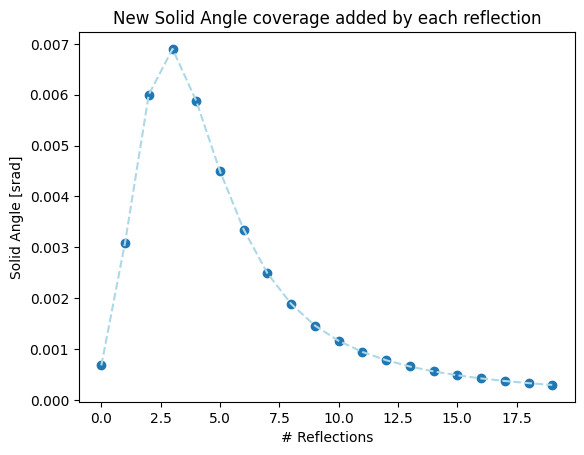

In [164]:
x = 20
plt.title("New Solid Angle coverage added by each reflection")
plt.ylabel("Solid Angle [srad]")
plt.xlabel("# Reflections")
plt.plot(np.arange(x), omega_sum[:x], 'o')
plt.plot(np.arange(x), omega_sum[:x], '--', color="lightblue")

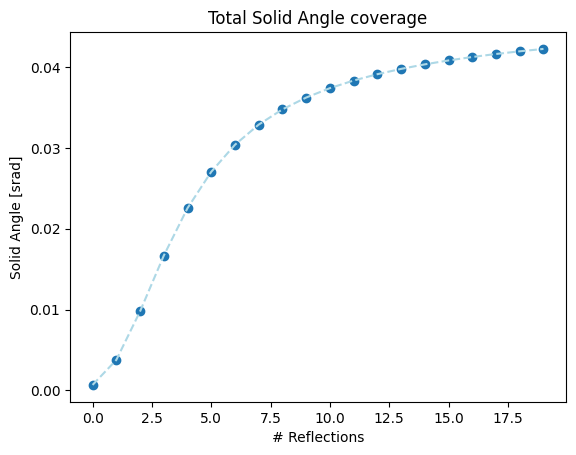

In [166]:
x = 20
plt.title("Total Solid Angle coverage")
plt.ylabel("Solid Angle [srad]")
plt.xlabel("# Reflections")
plt.plot(np.arange(x), omega_cum[:x], 'o')
plt.plot(np.arange(x), omega_cum[:x], '--', color="lightblue")

In [152]:
N = 50
tot_sum = []
tot_cum = []
for x_i in range(nCells[0]):
    for z_i in range(nCells[2]):
        omegas = compute_angles(edep_idx, (x_i, z_i), N)
        omega_sum = [np.sum(x) for x in omegas]
        omega_cum = list(accumulate(omega_sum))

        tot_sum.append(omega_sum)
        tot_cum.append(omega_cum)

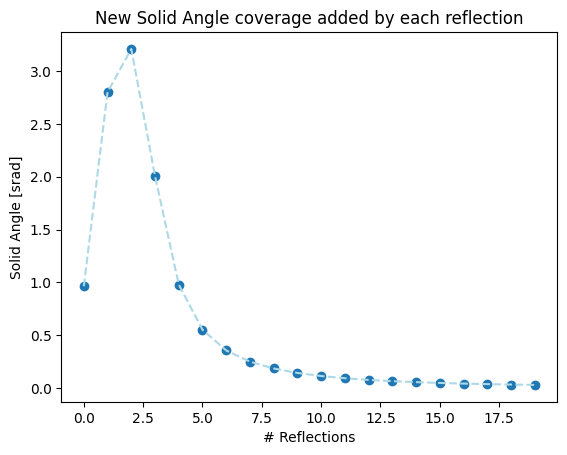

In [167]:
full_sum = [sum(values) for values in zip(*tot_sum)]
x = 20
plt.title("New Solid Angle coverage added by each reflection")
plt.ylabel("Solid Angle [srad]")
plt.xlabel("# Reflections")
plt.plot(np.arange(x), full_sum[:x], 'o')
plt.plot(np.arange(x), full_sum[:x], '--', color="lightblue")

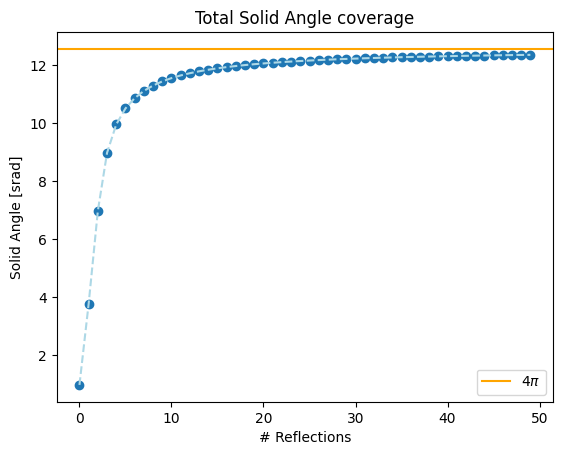

In [173]:
full_cum = [sum(values) for values in zip(*tot_cum)]
x = 50
plt.axhline(4*np.pi, label="$4\pi$", color='orange')
plt.title("Total Solid Angle coverage")
plt.ylabel("Solid Angle [srad]")
plt.xlabel("# Reflections")
plt.plot(np.arange(x), full_cum[:x], 'o')
plt.plot(np.arange(x), full_cum[:x], '--', color="lightblue")
plt.legend()